In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(microbenchmark)

rm(list=ls())



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Import Data

In [2]:
census_df <- read.csv('DATA/CHI_CommAreas_Census2010.csv', skip=1, header=TRUE)

head(census_df, 10)

Geog,GeogKey,Total.Population,Not.Hispanic.or.Latino..White.alone,Not.Hispanic.or.Latino..Black.or.African.American.alone,Not.Hispanic.or.Latino..American.Indian.and.Alaska.Native.alone,Not.Hispanic.or.Latino..Asian.alone,Not.Hispanic.or.Latino..Native.Hawaiian.and.Other.Pacific.Islander.alone,Not.Hispanic.or.Latino..Some.Other.Race.alone,Not.Hispanic.or.Latino..Two.or.More.Races,⋯,Median.Age,Total.Households,Average.Household.Size,Total.Housing.Units,Occupied.Housing.Units,Vacant.Housing.Units,Occupied.Housing.Units.1,Owned.with.a.mortgage.or.a.loan,Owned.free.and.clear,Renter.occupied
Rogers Park,1,54991,21618,14461,142,3523,39,202,1573,⋯,32.4,24292,2.13,27564,24292,3272,24292,6128,1009,17155
West Ridge,2,71942,30706,8015,189,16184,3,225,1919,⋯,35.1,24755,2.85,27466,24755,2711,24755,8829,3367,12559
Uptown,3,56362,29098,11275,191,6414,10,130,1235,⋯,35.5,29719,1.79,32541,29719,2822,29719,8298,1230,20191
Lincoln Square,4,39493,24916,1488,72,4399,11,128,917,⋯,33.5,18194,2.14,19906,18194,1712,18194,5482,1406,11306
North Center,5,31867,24634,738,55,1449,16,51,594,⋯,32.5,14561,2.18,16197,14561,1636,14561,5805,1147,7609
Lake View,6,94368,75845,3651,110,5653,44,140,1727,⋯,30.4,54425,1.72,59529,54425,5104,54425,16640,3488,34297
Lincoln Park,7,64116,53138,2753,54,3296,17,116,1171,⋯,28.9,33536,1.80,36864,33536,3328,33536,11409,2963,19164
Near North Side,8,80484,58033,8732,79,8140,25,163,1338,⋯,35.2,51714,1.52,62364,51714,10650,51714,17237,5991,28486
Edison Park,9,11187,9885,29,3,269,1,8,120,⋯,41.4,4726,2.37,4964,4726,238,4726,2478,1186,1062
Norwood Park,10,37023,30157,164,54,1696,1,38,471,⋯,43.0,14937,2.44,15848,14937,911,14937,7758,4009,3170


## Extract Data

In [3]:
extract_fct <- function() {
  race_df <<- census_df %>% select(., matches("Geog|Hispanic"))
  
  age_df <<- census_df %>% select(., matches("Geog|years"))
  
  gender_df <<- census_df %>% select(., matches("Geog|Population|Male|Female"))
  
  educ_df <<- read.csv('DATA/CHI_CommAreas_Educ2010.csv', header=TRUE)
  
  hholds_df <<- census_df %>% select(., matches("Geog|Households"))
  
  housing_df <<- census_df %>% select(., matches("Geog|Total\\.Housing|Occupied|Vacant"))
  
  occupied_df <<- census_df %>% select(., matches("Geog|Owned|Renter"))
}


In [8]:
extract_fct()

## Reshape Data

In [6]:
reshape_fct <- function() {
  # RACE
  race_long_df <<- race_df %>% gather(., key="Race_Ethnicity", value="Population", -Geog, -GeogKey)
  
  # AGE
  age_df[gsub("Male..", "Age.", names(age_df)[grep("Male", names(age_df))])] <<- select(age_df, matches("^Male")) +
    select(age_df, matches("Female"))
  
  age_long_df <<- age_df %>% 
    select(., matches("Geog|^Age")) %>%
    gather(., key="Age_Group", value="Population", -Geog, -GeogKey)
  
  # GENDER
  gender_df$male <<- rowSums(select(select(gender_df, matches("Geog|(^Male)")), -Geog, -GeogKey))
  gender_df$female <<- rowSums(select(select(gender_df, matches("Geog|Female")), -Geog, -GeogKey))
  
  gender_long_df <<- gender_df %>% 
    select(., matches("Geog|(^male)|female", ignore.case=FALSE)) %>%
    gather(., key="Gender", value="Population", -Geog, -GeogKey)
  
  # EDUCATION
  educ_long_df <<- educ_df %>% 
    select(., matches("Geog|Total")) %>%
    gather(., key="Education_Level", value="Population", -Geog, -GeogKey)
  
  # HOUSEHOLD
  hholds_long_df <<-hholds_df
  
  # HOUSING UNITS
  housing_long_df <<- housing_df %>%
    select(-Occupied.Housing.Units.1) %>%
    gather(., key="Occupied_Status", value="Housing_Units", -Geog, -GeogKey)
  
  # OCCUPIED HOUSING
  occupied_long_df <<- occupied_df %>%
    gather(., key="Occupied_Type", value="Housing_Units", -Geog, -GeogKey)                             
}


In [9]:
reshape_fct()

## Summarize Data

In [11]:
summarize_fct <- function() {
    
  # COMM AREA
  comm_aggdf <-  census_df %>%
    select(Total.Population) %>%
    summarise(mean_population = mean(Total.Population),
              median_population = median(Total.Population),
              min_population = min(Total.Population),
              max_population = max(Total.Population),
              total_population = sum(Total.Population))
  # RACE
  race_aggdf <- race_long_df %>%
    select(Race_Ethnicity, Population) %>%
    group_by(Race_Ethnicity) %>%
    summarise(mean_population = mean(Population),
              median_population = median(Population),
              min_population = min(Population),
              max_population = max(Population),
              total_population = sum(Population))
  
  # AGE
  age_aggdf <- age_long_df %>%
    select(Age_Group, Population) %>%
    group_by(Age_Group) %>%
    summarise(mean_population = mean(Population),
              median_population = median(Population),
              min_population = min(Population),
              max_population = max(Population),
              total_population = sum(Population))
  
  # GENDER
  gender_aggdf <- gender_long_df %>%
    select(Gender, Population) %>%
    group_by(Gender) %>%
    summarise(mean_population = mean(Population),
              median_population = median(Population),
              min_population = min(Population),
              max_population = max(Population),
              total_population = sum(Population))
  
  # EDUCATION
  educ_aggdf <- educ_long_df %>%
    select(Education_Level, Population) %>%
    group_by(Education_Level) %>%
    summarise(mean_population = mean(Population),
              median_population = median(Population),
              min_population = min(Population),
              max_population = max(Population),
              total_population = sum(Population))
  
  # HOUSEHOLDS
  hhold_aggdf <- hholds_long_df %>%
    summarise(mean_households = mean(Total.Households),
              median_households = median(Total.Households),
              min_households = min(Total.Households),
              max_households = max(Total.Households),
              total_households = sum(Total.Households))
  
  # HOUSING UNITS
  housing_aggdf <- housing_long_df %>%
    select(Occupied_Status, Housing_Units) %>%
    group_by(Occupied_Status) %>%
    summarise(mean_housing_units = mean(Housing_Units),
              median_housing_units = median(Housing_Units),
              min_housing_units = min(Housing_Units),
              max_housing_units = max(Housing_Units),
              total_housing_units = sum(Housing_Units))
  
  # OCCUPIED 
  occupied_aggdf <- occupied_long_df %>%
    select(Occupied_Type, Housing_Units) %>%
    group_by(Occupied_Type) %>%
    summarise(mean_housing_units = mean(Housing_Units),
              median_housing_units = median(Housing_Units),
              min_housing_units = min(Housing_Units),
              max_housing_units = max(Housing_Units),
              total_housing_units = sum(Housing_Units))
  
  list(comm_aggdf, race_aggdf, age_aggdf, gender_aggdf, educ_aggdf, hhold_aggdf, housing_aggdf, occupied_aggdf)
}


In [12]:
summarize_fct()

[[1]]
  mean_population median_population min_population max_population
1        35007.77             31028           2876          98514
  total_population
1          2695598

[[2]]
# A tibble: 8 x 6
                                                            Race_Ethnicity
                                                                     <chr>
1                                                       Hispanic.or.Latino
2          Not.Hispanic.or.Latino..American.Indian.and.Alaska.Native.alone
3                                      Not.Hispanic.or.Latino..Asian.alone
4                  Not.Hispanic.or.Latino..Black.or.African.American.alone
5 Not.Hispanic.or.Latino..Native.Hawaiian.and.Other.Pacific.Islander.alone
6                            Not.Hispanic.or.Latino..Some.Other.Race.alone
7                                Not.Hispanic.or.Latino..Two.or.More.Races
8                                      Not.Hispanic.or.Latino..White.alone
# ... with 5 more variables: mean_population <dbl>, median_population <int>,
#   min_population <dbl>, max_population <dbl>, total_population <int>

[[3]]
# A tibble: 23 x 6
             Age_Group mean_population median_population min_population
                 <chr>           <dbl>             <int>          <dbl>
 1  Age.10.to.14.years       2135.9221              1688            192
 2  Age.15.to.17.years       1366.2338              1182            147
 3 Age.18.and.19.years       1009.5195               820             85
 4        Age.20.years        533.3896               451             27
 5        Age.21.years        521.2727               439             34
 6  Age.22.to.24.years       1841.7922              1327             89
 7  Age.25.to.29.years       3586.2208              2163            156
 8  Age.30.to.34.years       3109.2468              1991            161
 9  Age.35.to.39.years       2604.0000              1939            161
10  Age.40.to.44.years       2306.8961              1887            148
# ... with 13 more rows, and 2 more variables: max_population <dbl>,
#   total_population <int>

[[4]]
# A tibble: 2 x 6
  Gender mean_population median_population min_population max_population
   <chr>           <dbl>             <dbl>          <dbl>          <dbl>
1 female        18019.82             16310           1485          53325
2   male        16987.95             14245           1286          47000
# ... with 1 more variables: total_population <dbl>

[[5]]
# A tibble: 6 x 6
                                  Education_Level mean_population
                                            <chr>           <dbl>
1                         Total.25.years.and.over       22961.727
2               Total.Bachelor.s.degree.or.higher        7404.338
3 Total.High.school.graduate..GED..or.alternative        5487.935
4             Total.Less.than.high.school.diploma        4732.792
5                                Total.Population       35007.766
6        Total.Some.college.or.associate.s.degree        5336.662
# ... with 4 more variables: median_population <int>, min_population <dbl>,
#   max_population <dbl>, total_population <int>

[[6]]
  mean_households median_households min_households max_households
1         13578.7             11064           1077          54425
  total_households
1          1045560

[[7]]
# A tibble: 4 x 6
         Occupied_Status mean_housing_units median_housing_units
                   <chr>              <dbl>                <int>
1 Occupied.Housing.Units          13578.701                11064
2        Renter.occupied           7480.494                 6288
3    Total.Housing.Units          15510.870                13422
4   Vacant.Housing.Units           1932.169                 1712
# ... with 3 more variables: min_housing_units <dbl>, max_housing_units <dbl>,
#   total_housing_units <int>

[[8]]
# A tibble: 3 x 6
                    Occupied_Type mean_housing_units median_housing_units
                            <chr>              <dbl>                

## Graphing Data

In [9]:
graphing_fct <- function() {
  
  # COMM AREA
  comm_plot <- census_df %>%
    top_n(n=10, wt=Total.Population) %>%
    ggplot(aes(x=Geog, y=Total.Population, fill=factor(Geog))) + 
    geom_bar(stat="identity", position = position_dodge(width = 0.9)) +
    guides(fill=FALSE) +
    labs(title="Top Ten Chicago Community Areas - Top Ten Population", 
         y="Total Population", x="Chicago Community Areas") +
    theme(plot.title = element_text(hjust = 0.5), legend.position="bottom") + 
    scale_fill_hue(l=45)
  
  # RACE
  plots <- race_long_df %>%
    group_by(Race_Ethnicity) %>%
    top_n(n=10, wt=Population) %>%
    do(plots=ggplot(., aes(x=Geog, y=Population, fill=factor(Geog))) + 
         geom_bar(stat="identity", position = position_dodge(width = 0.9)) +
         guides(fill=guide_legend(title="Geog", ncol=15)) +
         labs(title=gsub("\\.", " ", paste("Top Ten Chicago Community Area ", unique(.$Race_Ethnicity), sep=" - ")), 
              y="Population", x="Chicago Community Areas") +
         theme(plot.title = element_text(hjust = 0.5), legend.position="bottom") + 
         scale_fill_hue(l=45))
  race_plots <- plots$plots
  
  # AGE
  plots <- age_long_df %>%
    group_by(Age_Group) %>%
    top_n(n=10, wt=Population) %>%
    do(plots=ggplot(., aes(x=Geog, y=Population, fill=factor(Geog))) + 
         geom_bar(stat="identity", position = position_dodge(width = 0.9)) +
         guides(fill=guide_legend(title="Geog", ncol=15)) +
         labs(title=gsub("\\.", " ", paste("Top Ten Chicago Community Area ", unique(.$Age_Group), sep=" - ")), 
              y="Population", x="Chicago Community Areas") +
         theme(plot.title = element_text(hjust = 0.5), legend.position="bottom") + 
         scale_fill_hue(l=45))
  
  age_plots <- plots$plots
  
  # GENDER
  plots <- gender_long_df %>%
    group_by(Gender) %>%
    top_n(n=10, wt=Population) %>%
    do(plots=ggplot(., aes(x=Geog, y=Population, fill=factor(Geog))) + 
         geom_bar(stat="identity", position = position_dodge(width = 0.9)) +
         guides(fill=guide_legend(title="Geog", ncol=15)) +
         labs(title=gsub("\\.", " ", paste("Top Ten Chicago Community Area ", unique(.$Gender), sep=" - ")), 
              y="Population", x="Chicago Community Areas") +
         theme(plot.title = element_text(hjust = 0.5), legend.position="bottom") + 
         scale_fill_hue(l=45))
  
  gender_plots <- plots$plots
  
  # EDUCATION
  plots <- educ_long_df %>%
    group_by(Education_Level) %>%
    top_n(n=10, wt=Population) %>%
    do(plots=ggplot(., aes(x=Geog, y=Population, fill=factor(Geog))) + 
         geom_bar(stat="identity", position = position_dodge(width = 0.9)) +
         guides(fill=guide_legend(title="Geog", ncol=15)) +
         labs(title=gsub("\\.", " ", paste("Top Ten Chicago Community Area ", unique(.$Education_Level), sep=" - ")), 
              y="Population", x="Chicago Community Areas") +
         theme(plot.title = element_text(hjust = 0.5), legend.position="bottom") + 
         scale_fill_hue(l=45))
  
  educ_plots <- plots$plots
  
  # HOUSEHOLDS
  hhold_plot <- hholds_long_df %>%
    top_n(n=10, wt=Total.Households) %>%
    ggplot(aes(x=Geog, y=Total.Households, fill=factor(Geog))) + 
    geom_bar(stat="identity", position = position_dodge(width = 0.9)) +
    guides(fill=FALSE) +
    labs(title="Top Ten Chicago Community Areas - Top Ten Households", 
         y="Total Households", x="Chicago Community Areas") +
    theme(plot.title = element_text(hjust = 0.5), legend.position="bottom") + 
    scale_fill_hue(l=45)
  
  # HOUSING
  plots <- housing_long_df %>%
    group_by(Occupied_Status) %>%
    top_n(n=10, wt=Housing_Units) %>%
    do(plots=ggplot(., aes(x=Geog, y=Housing_Units, fill=factor(Geog))) + 
         geom_bar(stat="identity", position = position_dodge(width = 0.9)) +
         guides(fill=guide_legend(title="Geog", ncol=15)) +
         labs(title=gsub("\\.", " ", paste("Top Ten Chicago Community Area ", unique(.$Occupied_Status), sep=" - ")), 
              y="Housing_Units", x="Chicago Community Areas") +
         theme(plot.title = element_text(hjust = 0.5), legend.position="bottom") + 
         scale_fill_hue(l=45))
  
  housing_plots <- plots$plots
  
  # OCCUPIED HOUSING
  plots <- occupied_long_df %>%
    group_by(Occupied_Type) %>%
    top_n(n=10, wt=Housing_Units) %>%
    do(plots=ggplot(., aes(x=Geog, y=Housing_Units, fill=factor(Geog))) + 
         geom_bar(stat="identity", position = position_dodge(width = 0.9)) +
         guides(fill=guide_legend(title="Geog", ncol=15)) +
         labs(title=gsub("\\.", " ", paste("Top Ten Chicago Community Area ", unique(.$Occupied_Type), sep=" - ")), 
              y="Housing_Units", x="Chicago Community Areas") +
         theme(plot.title = element_text(hjust = 0.5), legend.position="bottom") + 
         scale_fill_hue(l=45))
  
  occupied_plots <- plots$plots
  
  list(comm_plot, race_plots, age_plots, gender_plots, educ_plots, hhold_plot, housing_plots, occupied_plots)
}


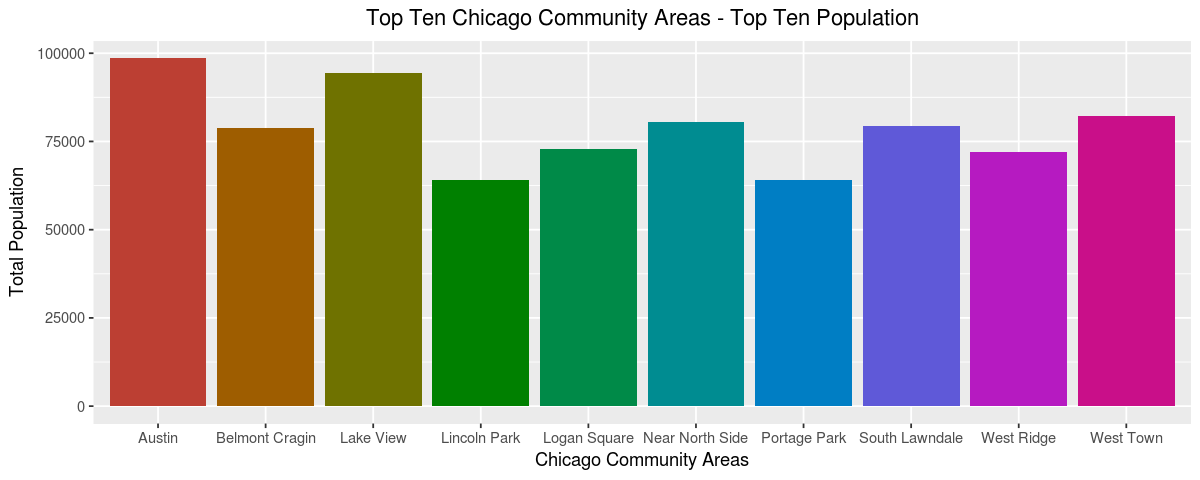

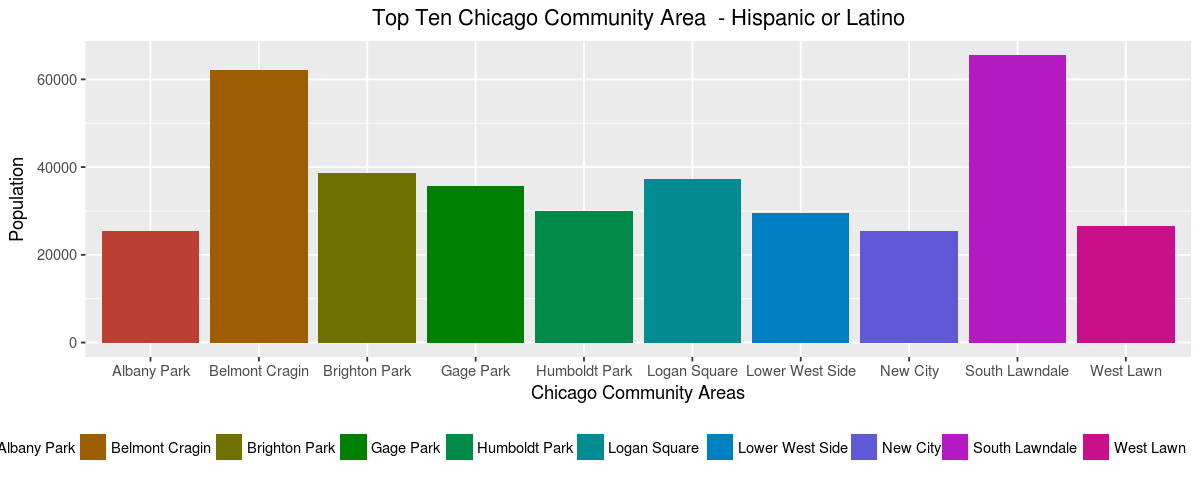

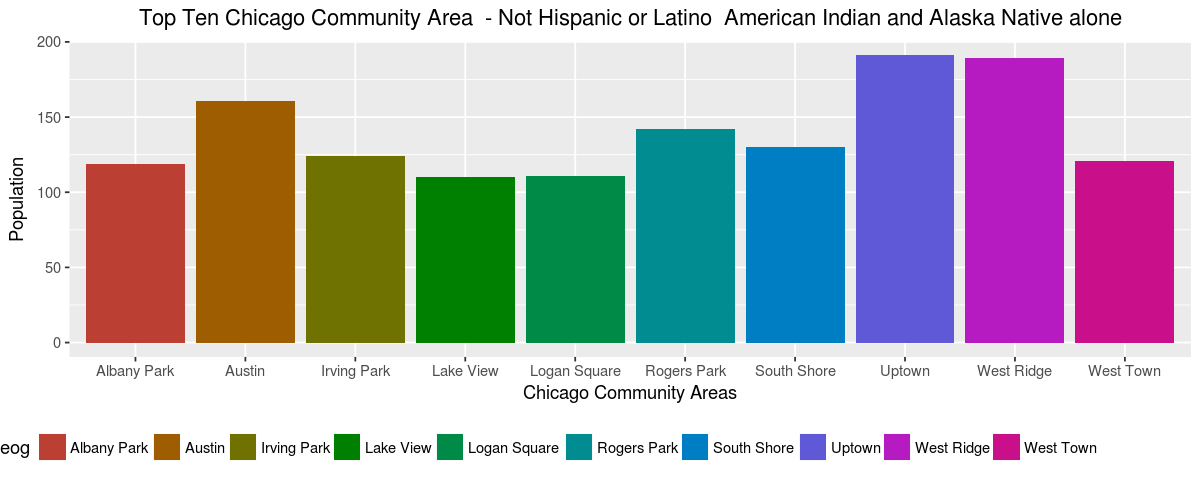

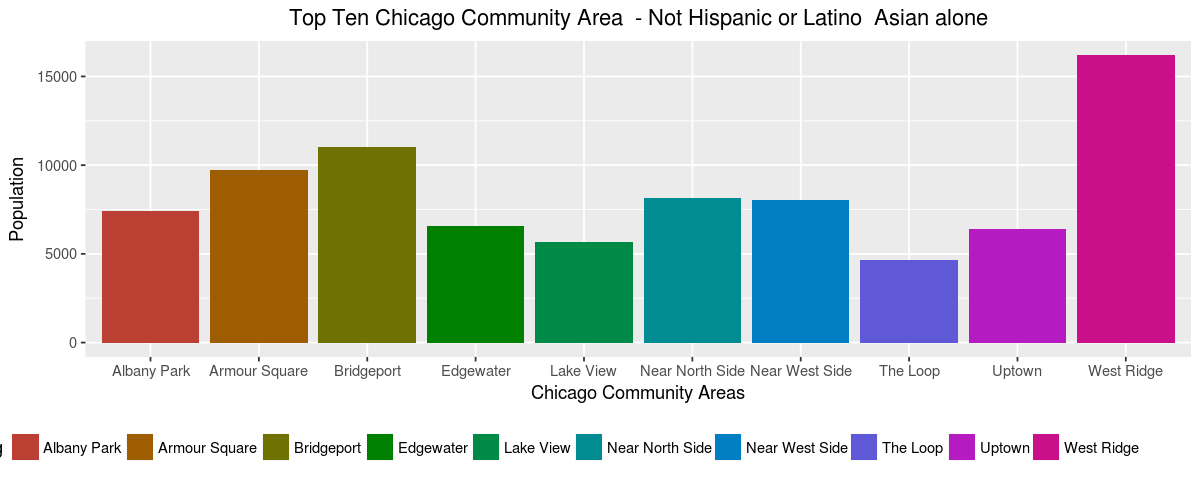

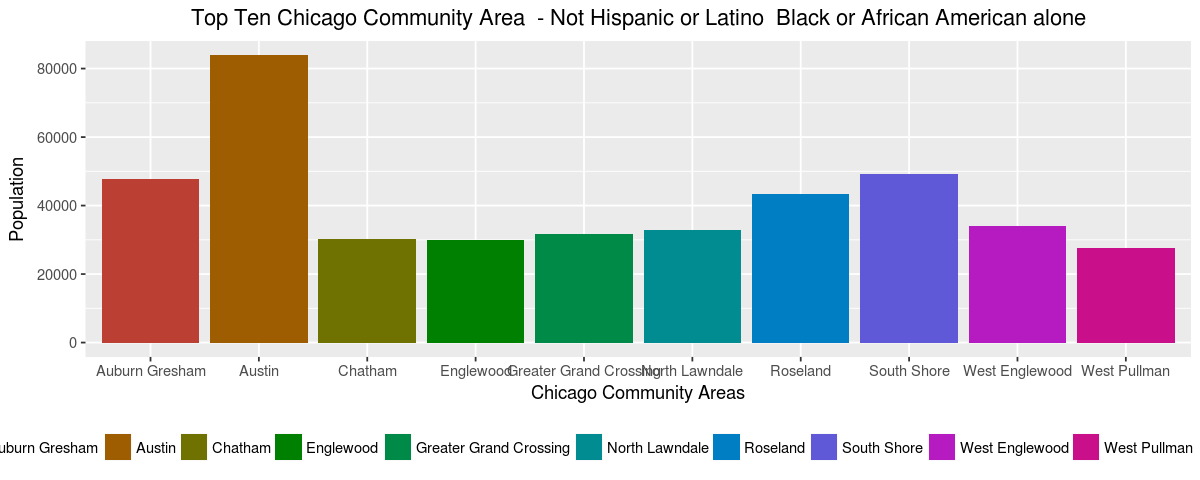

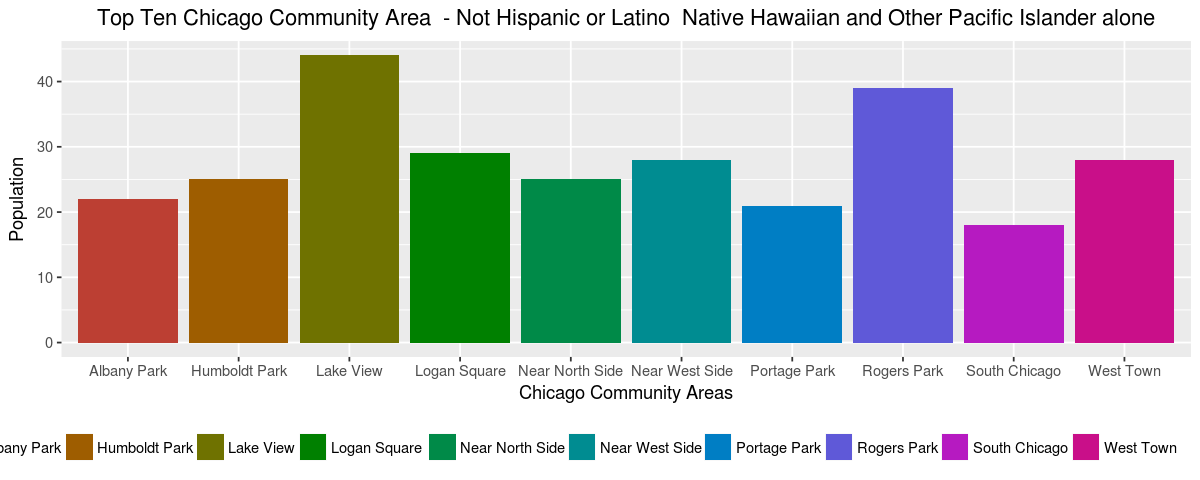

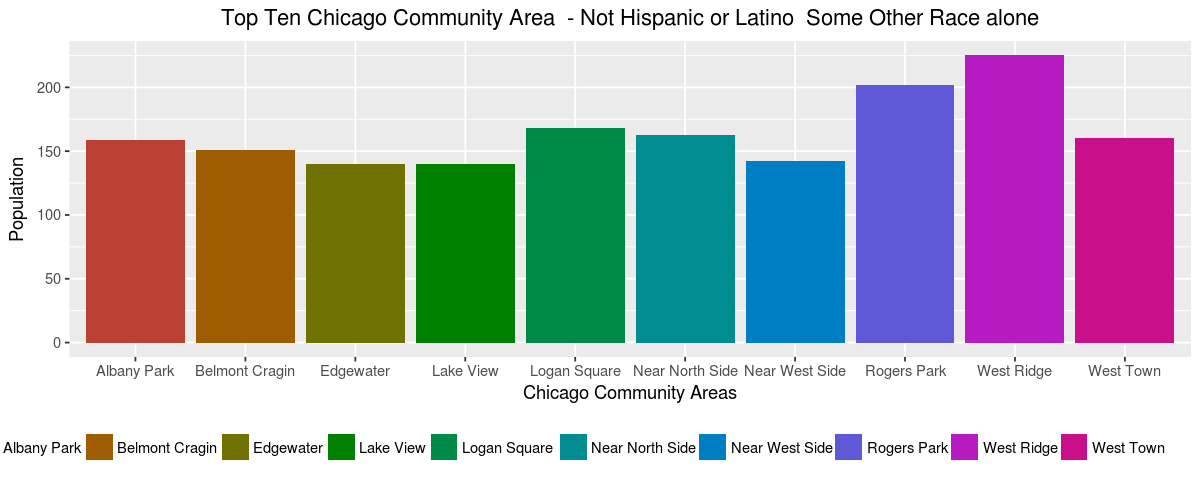

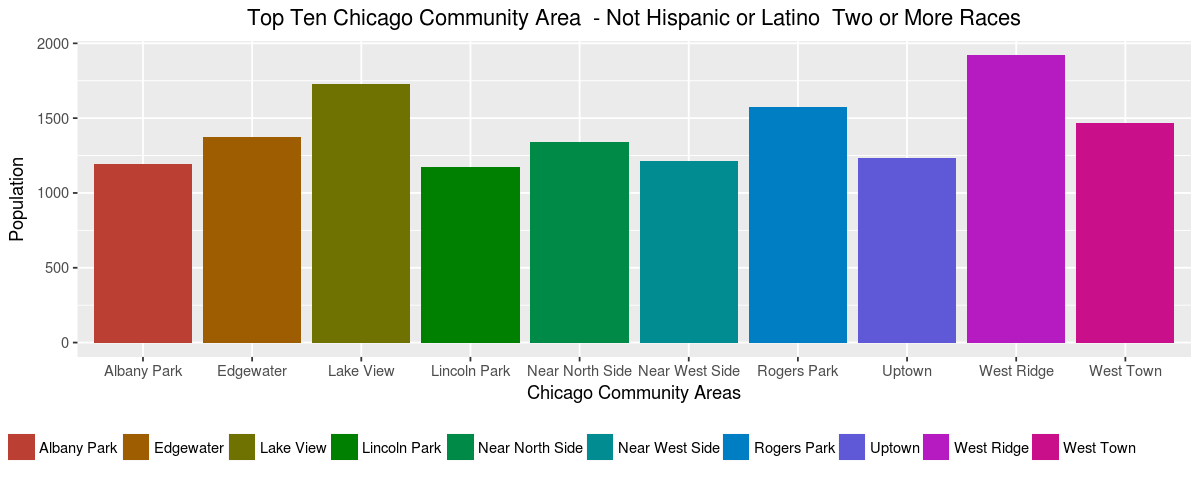

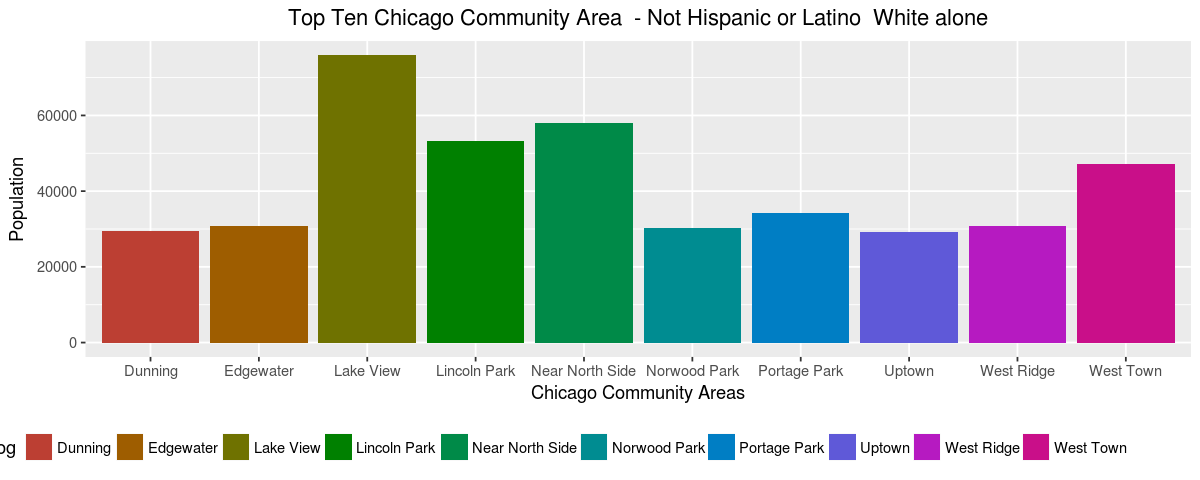

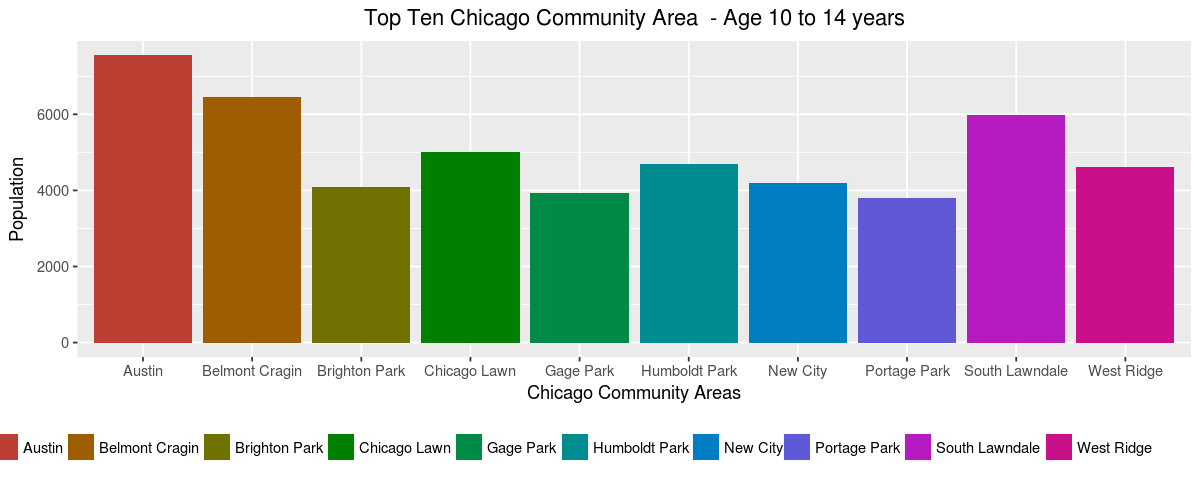

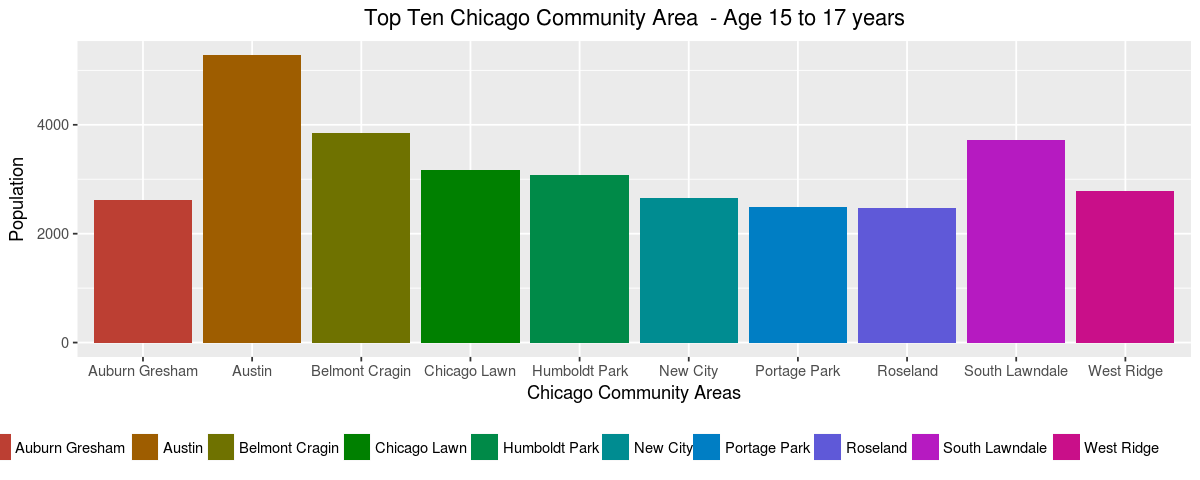

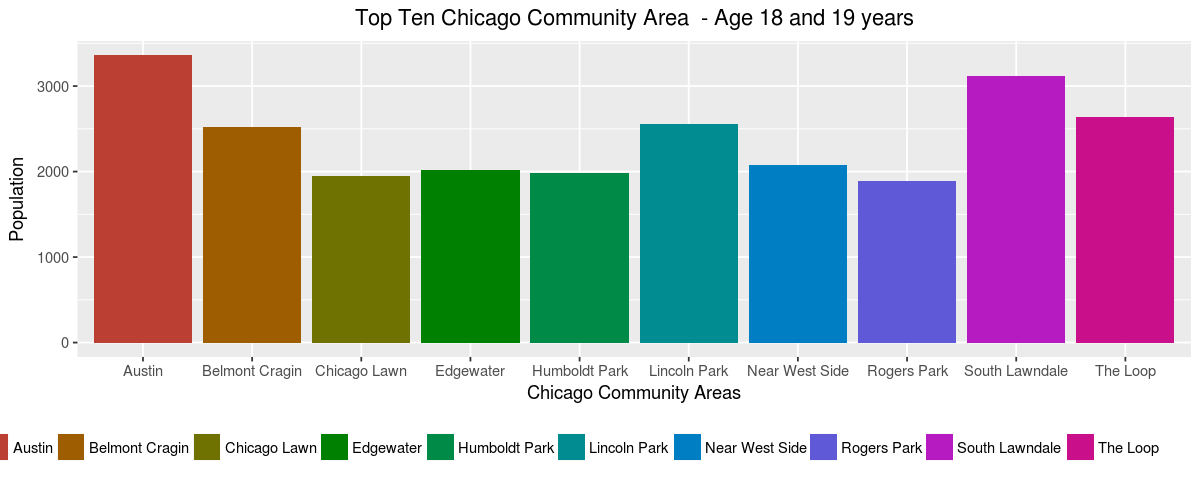

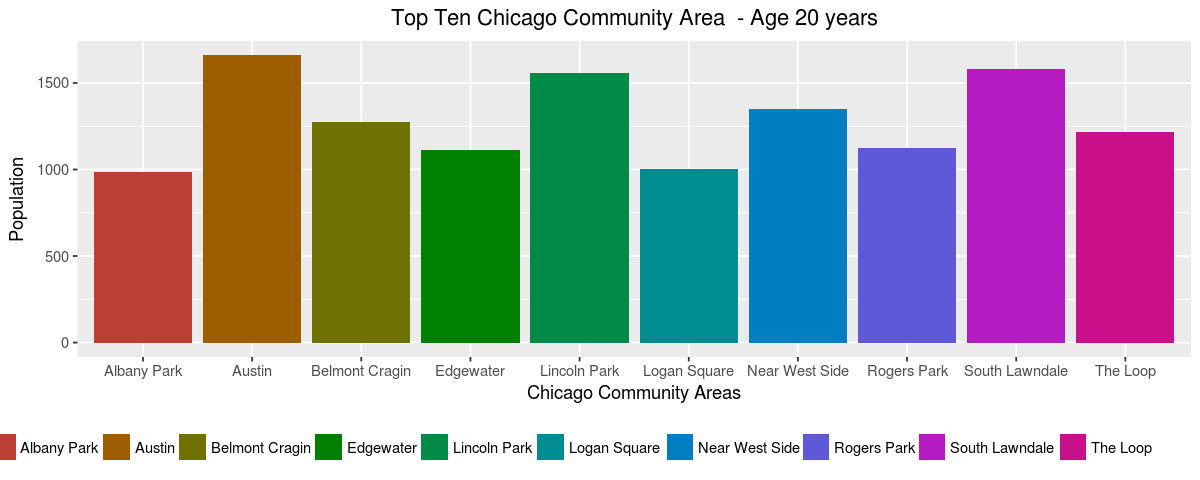

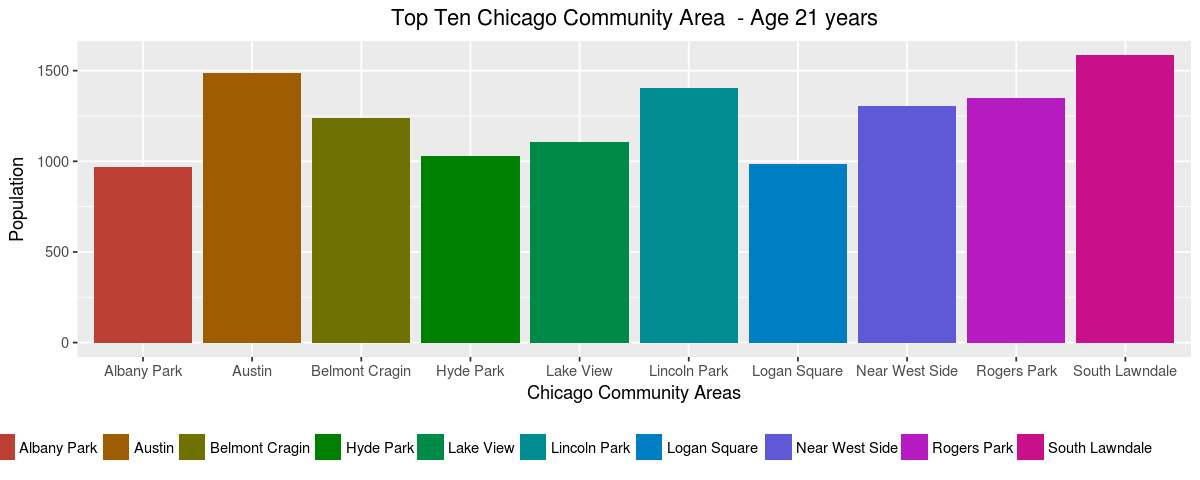

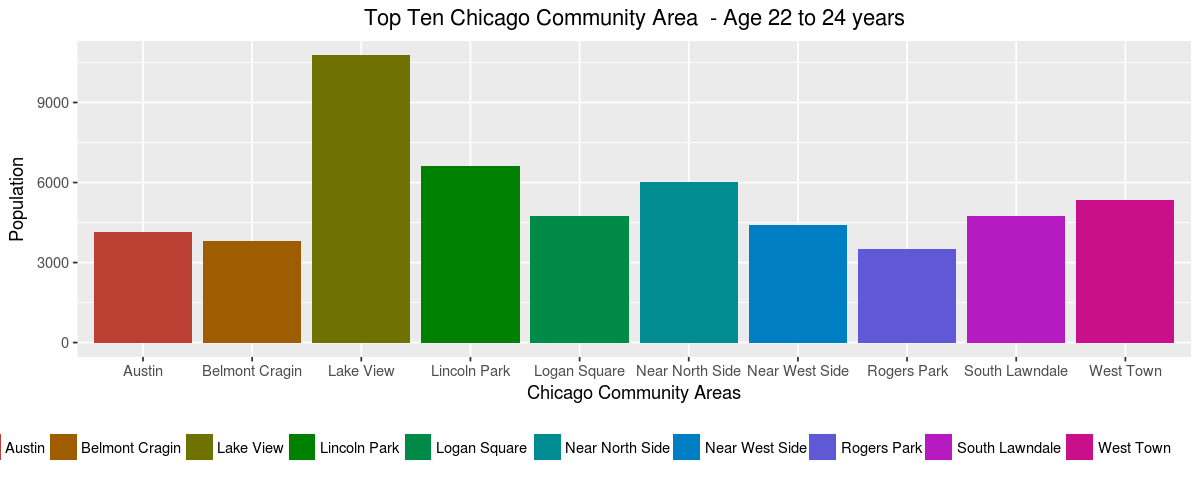

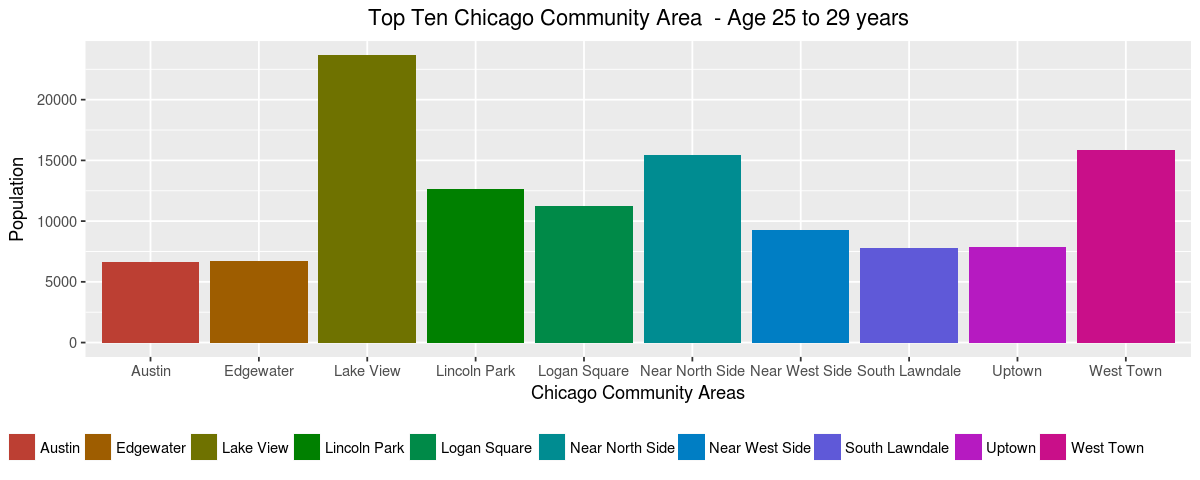

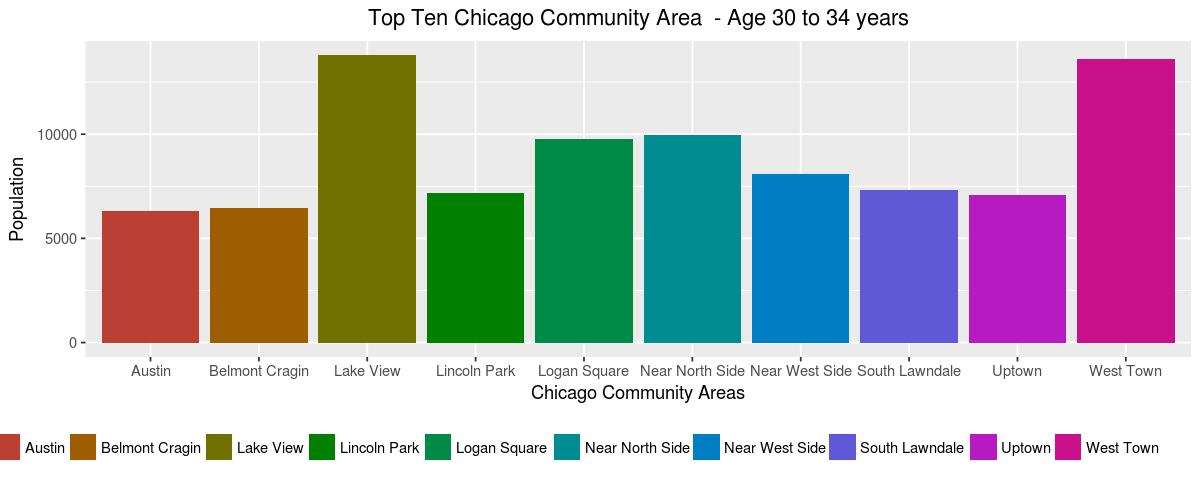

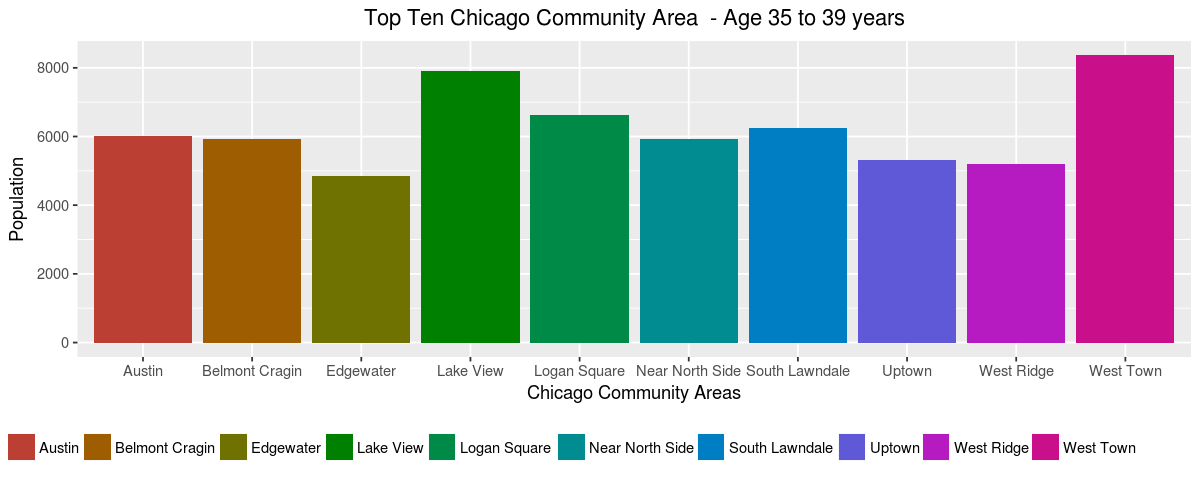

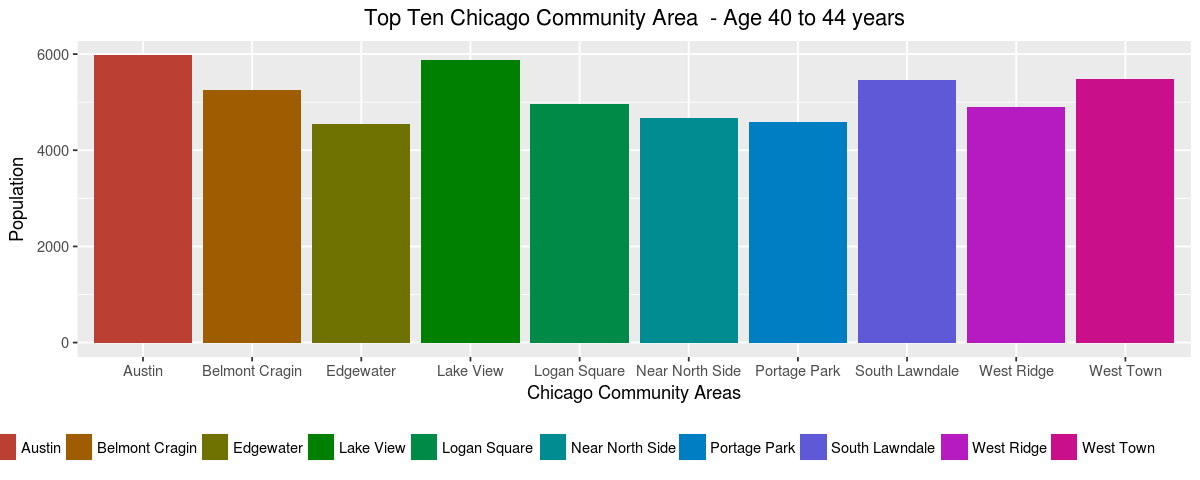

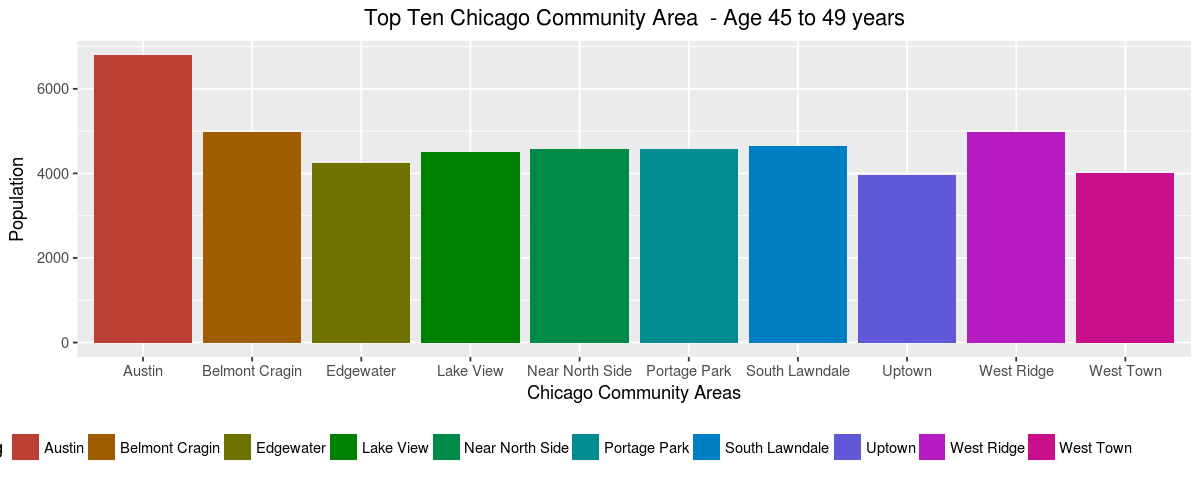

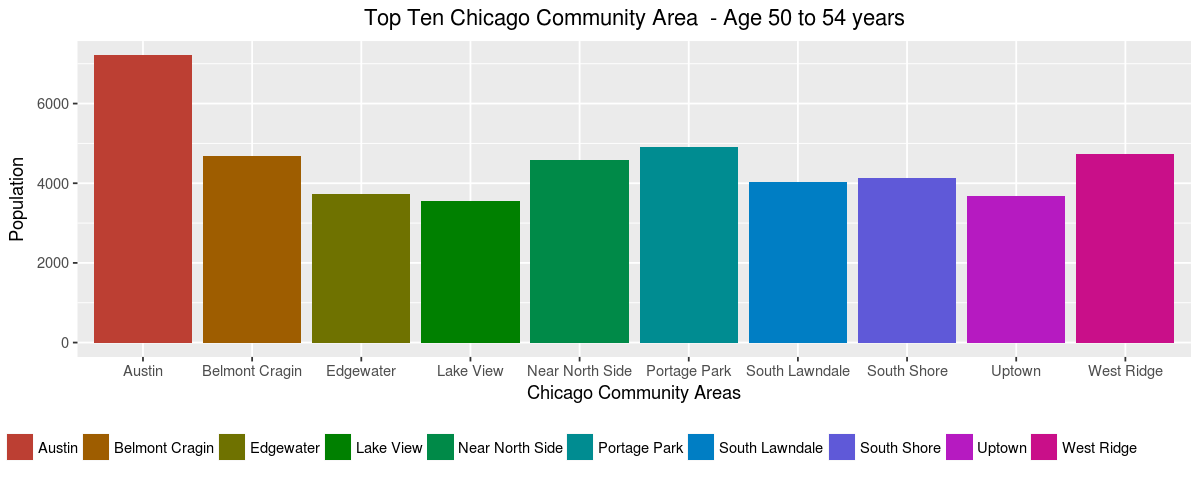

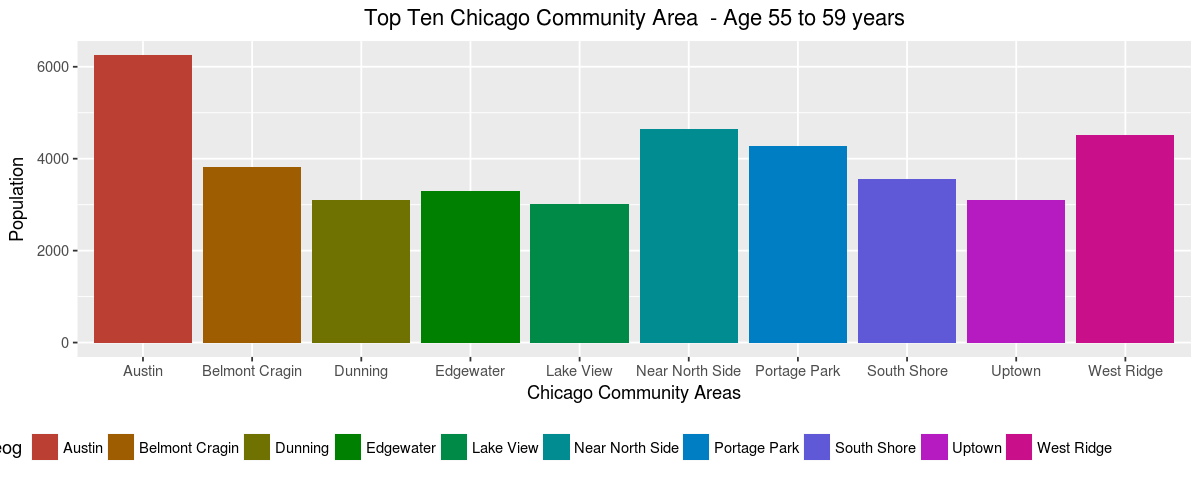

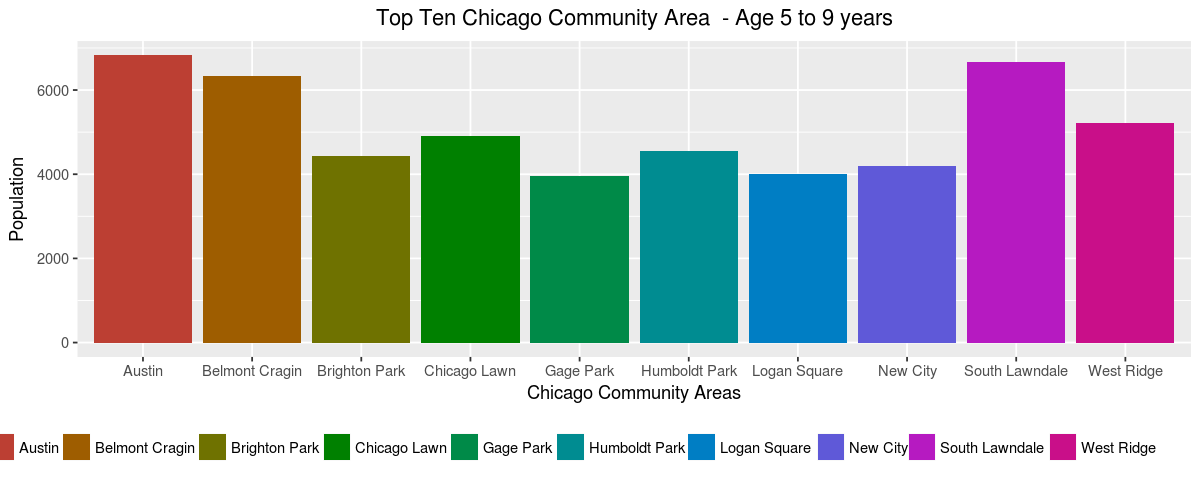

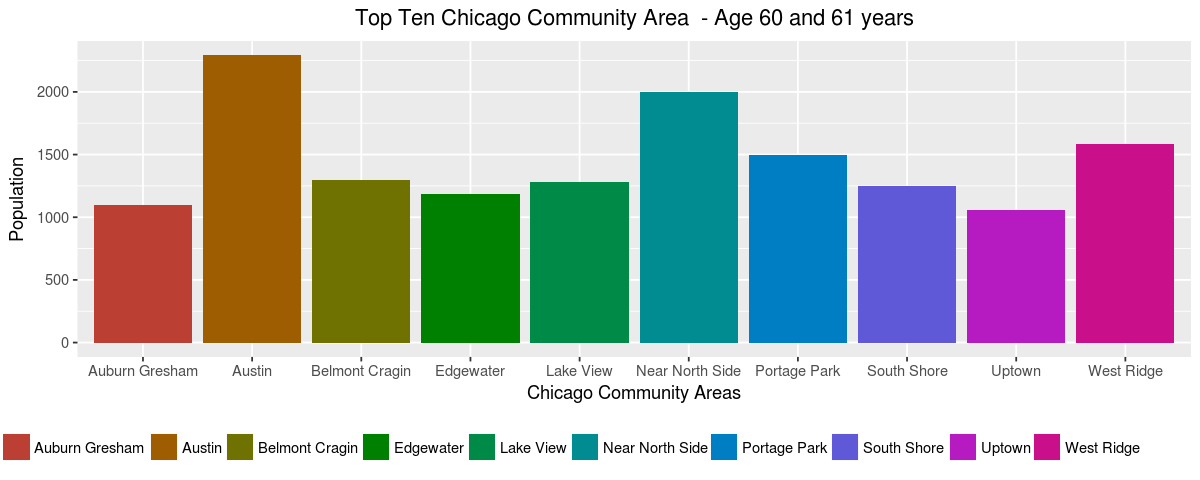

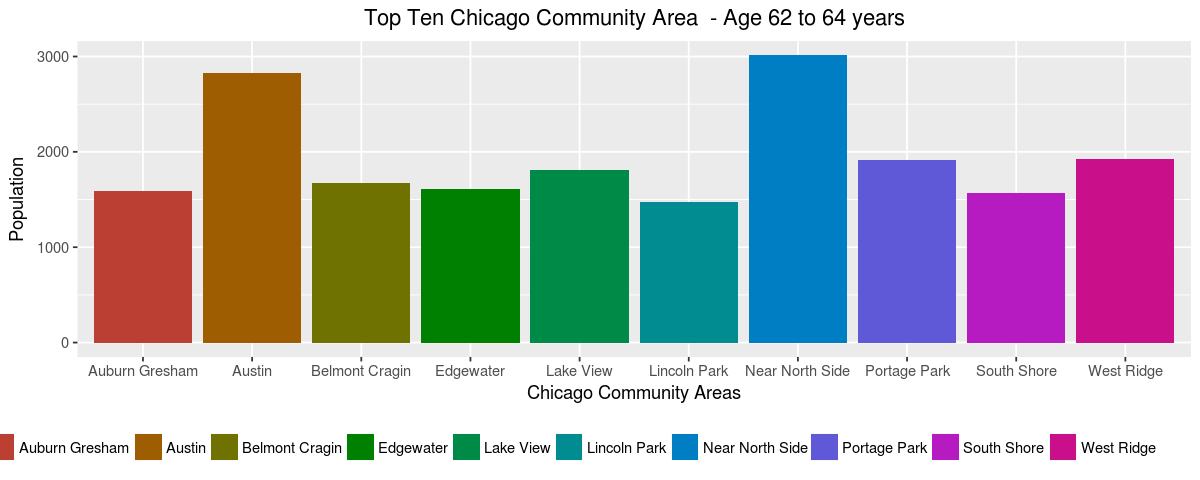

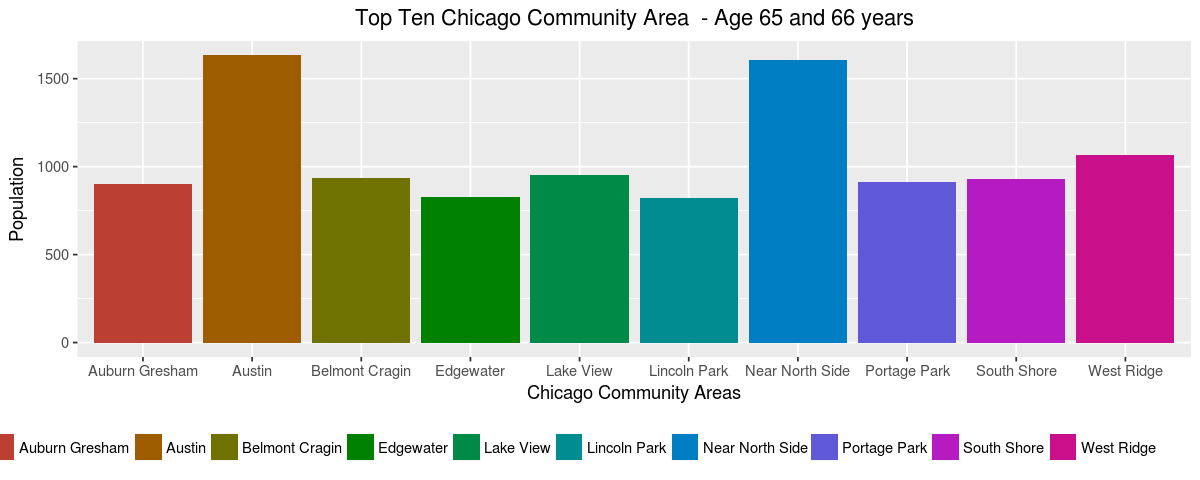

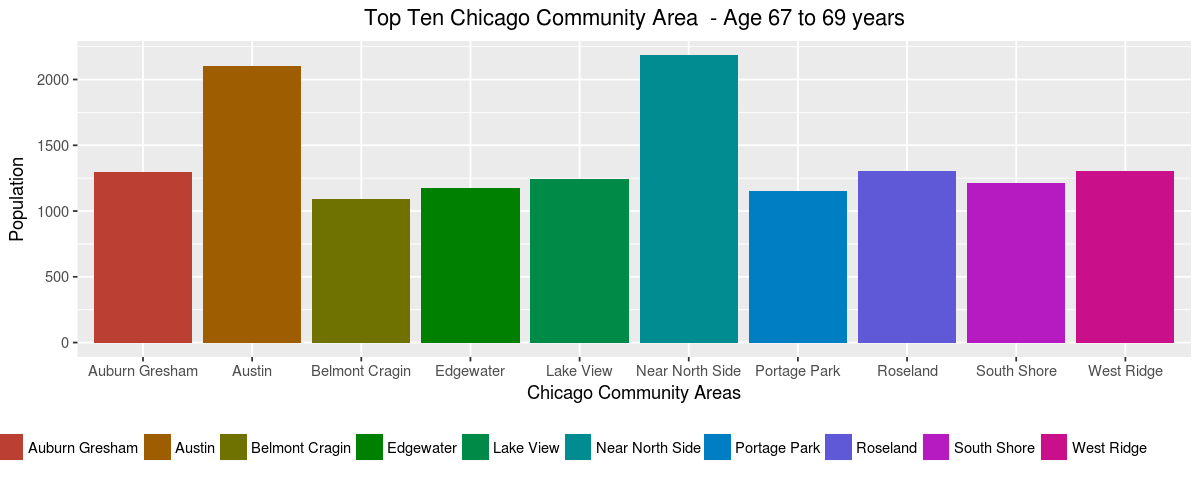

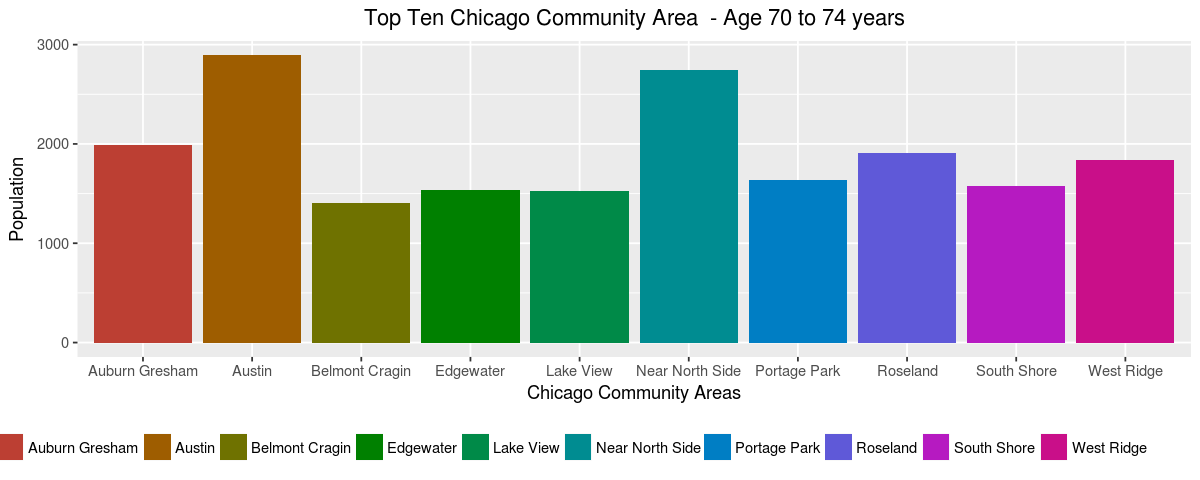

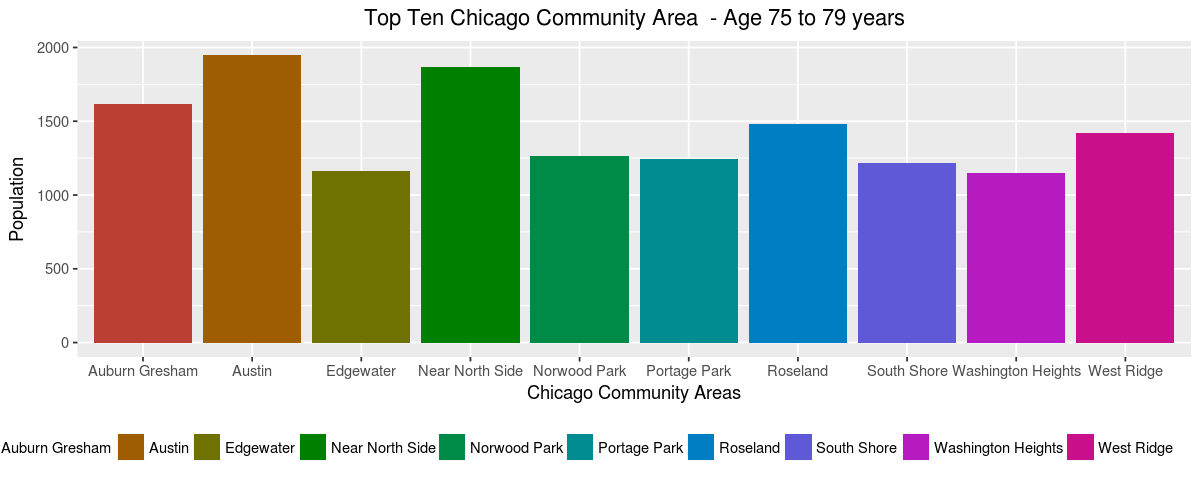

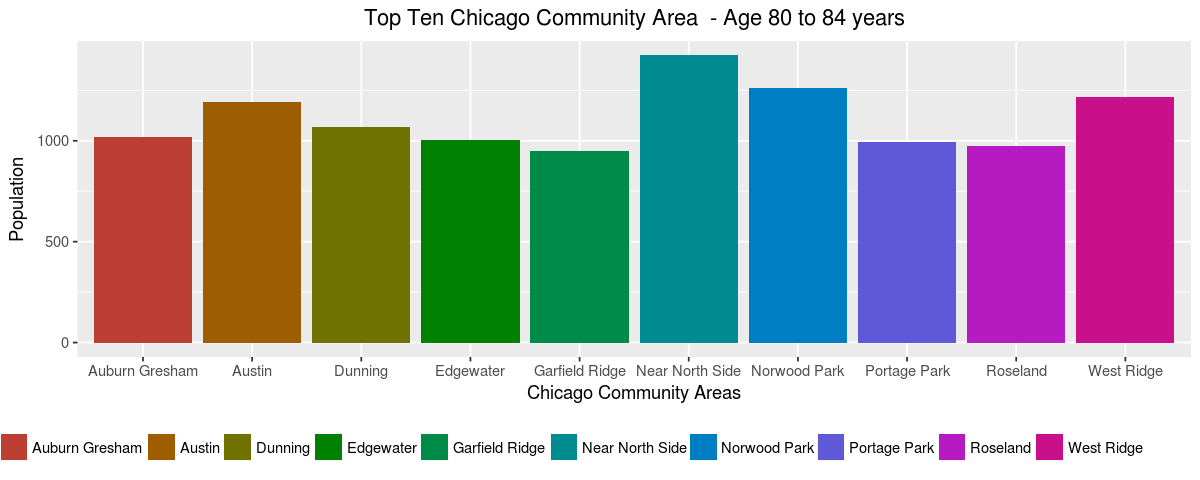

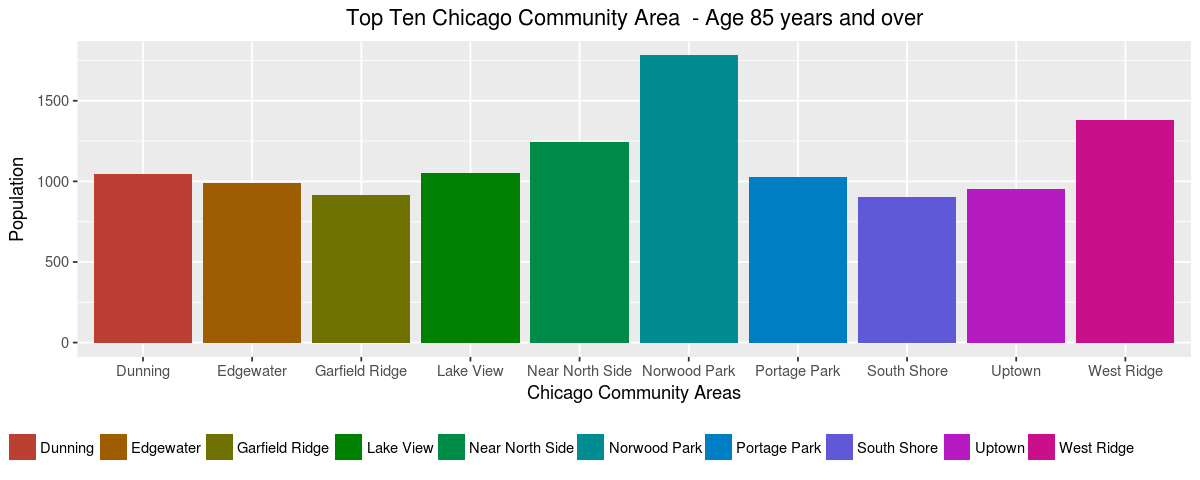

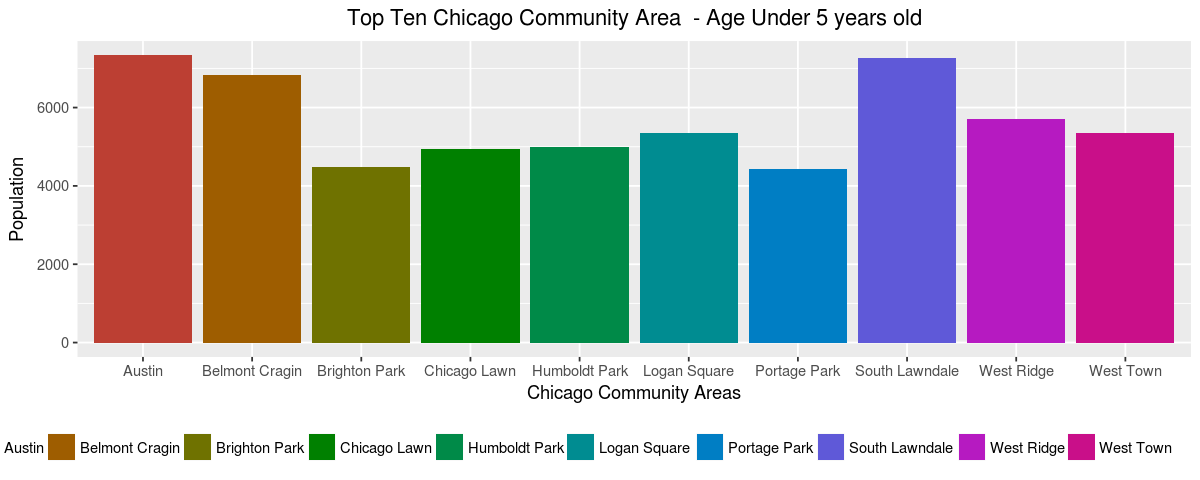

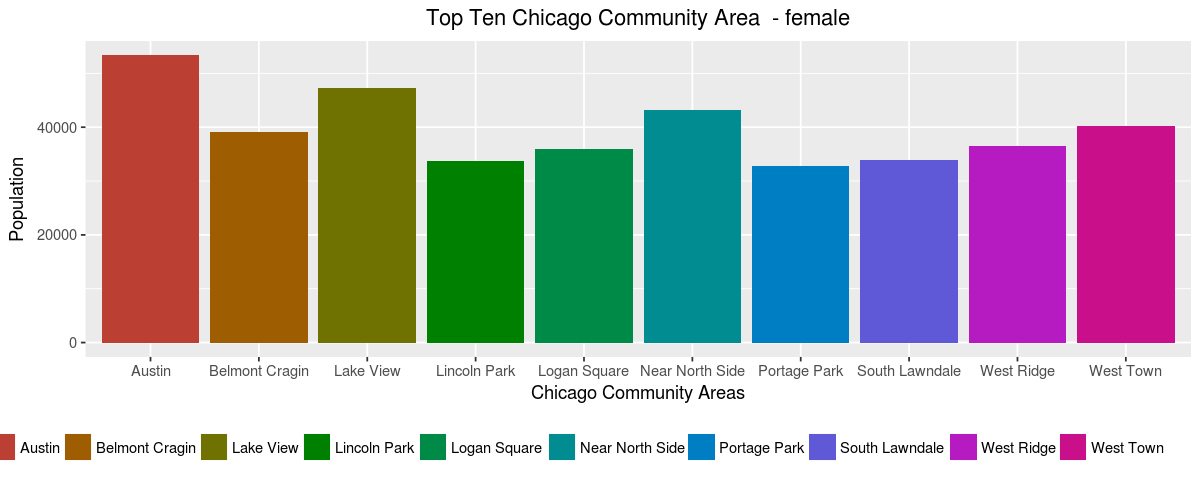

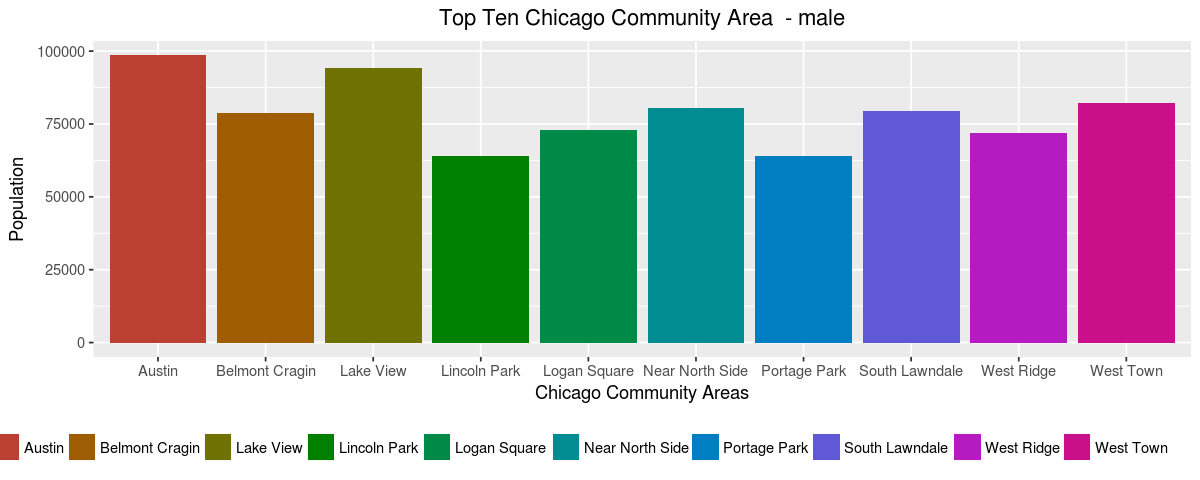

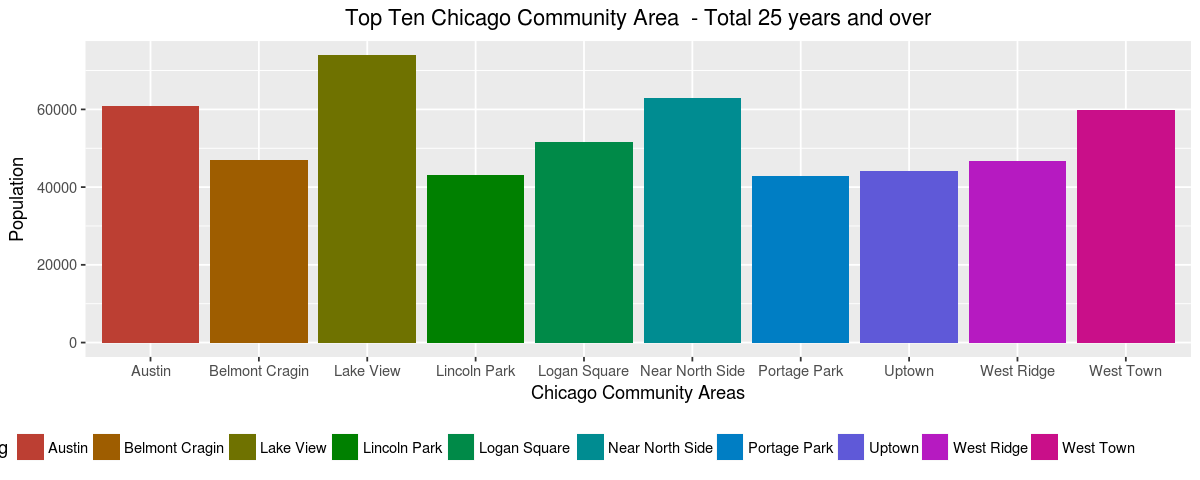

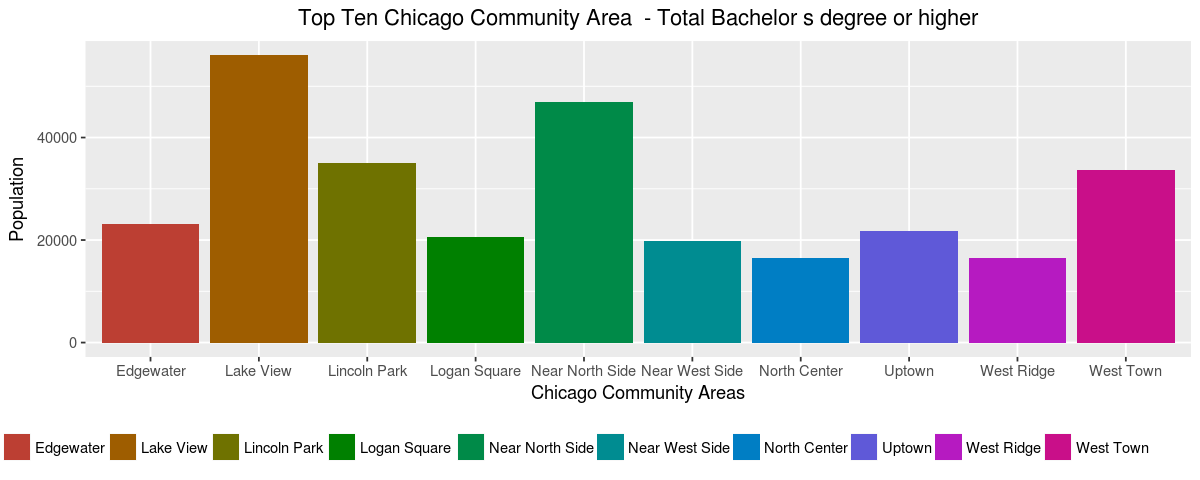

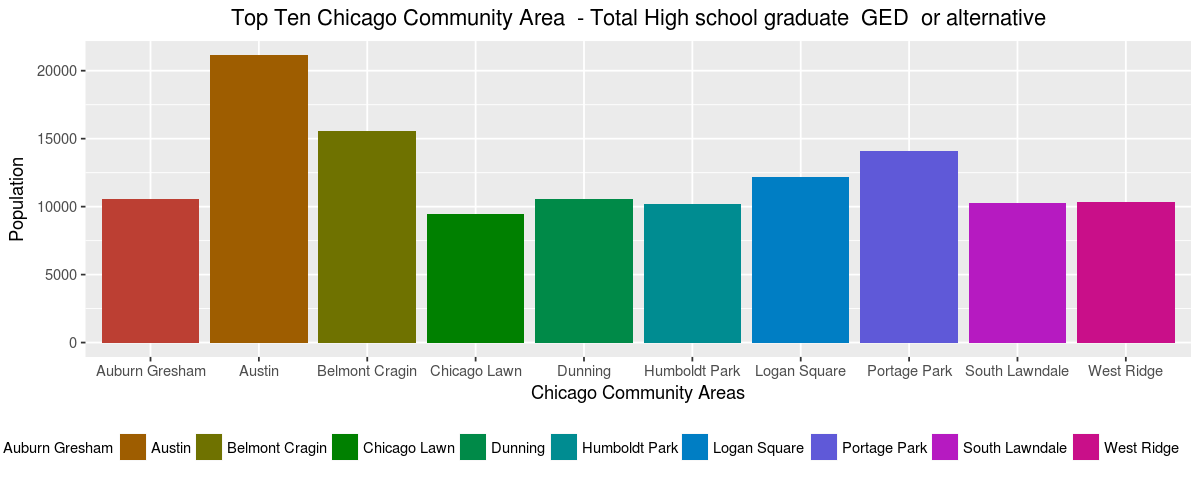

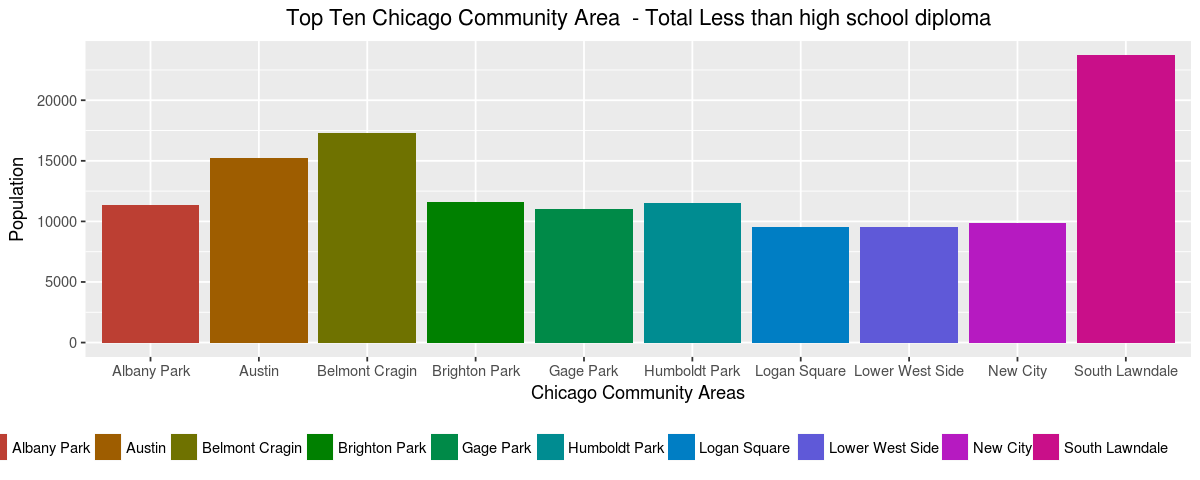

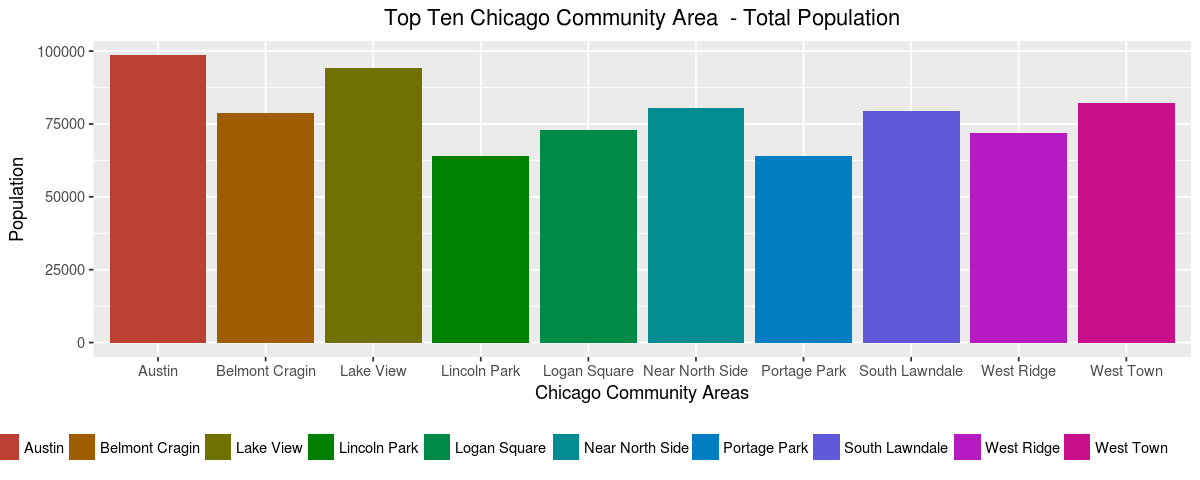

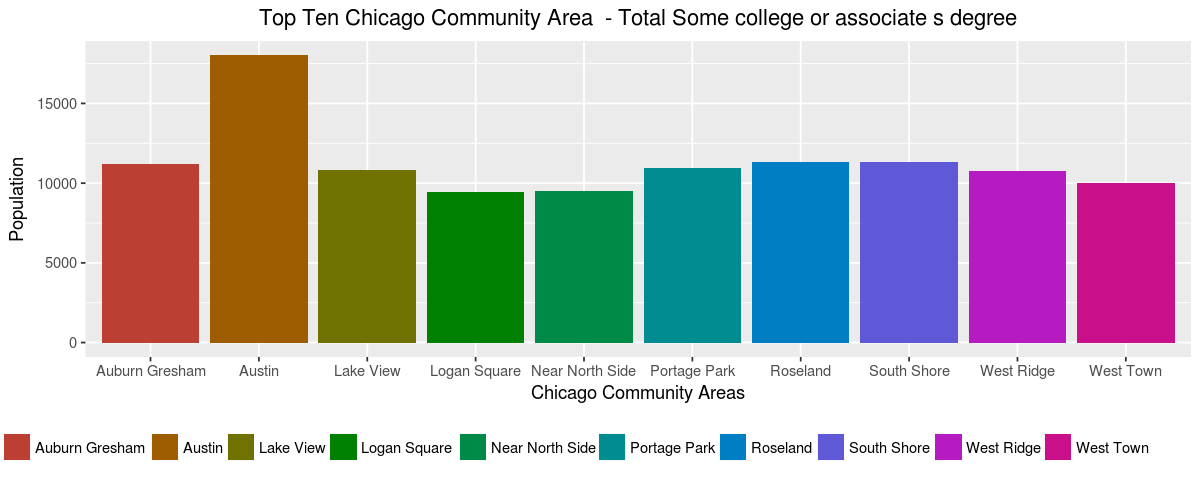

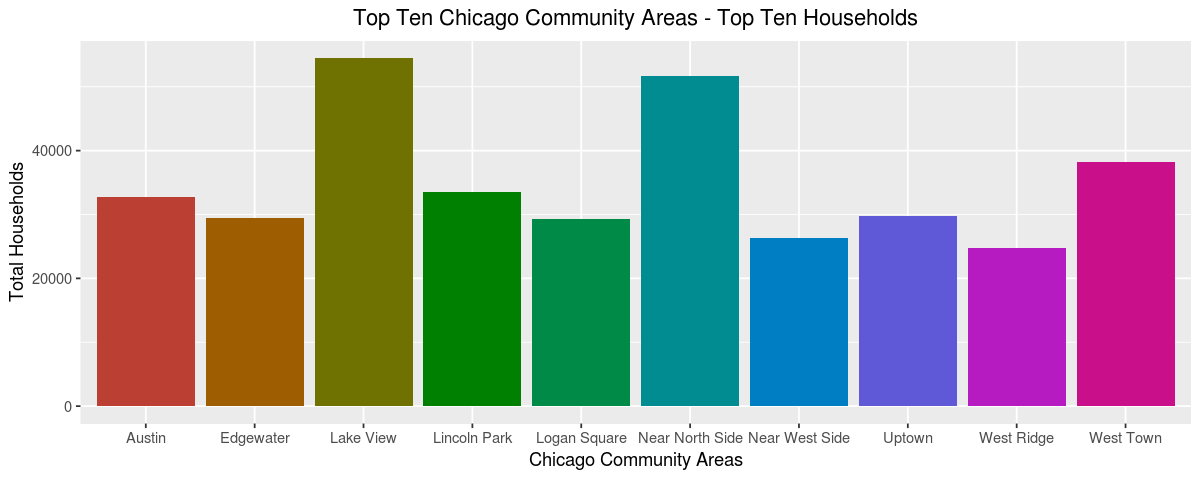

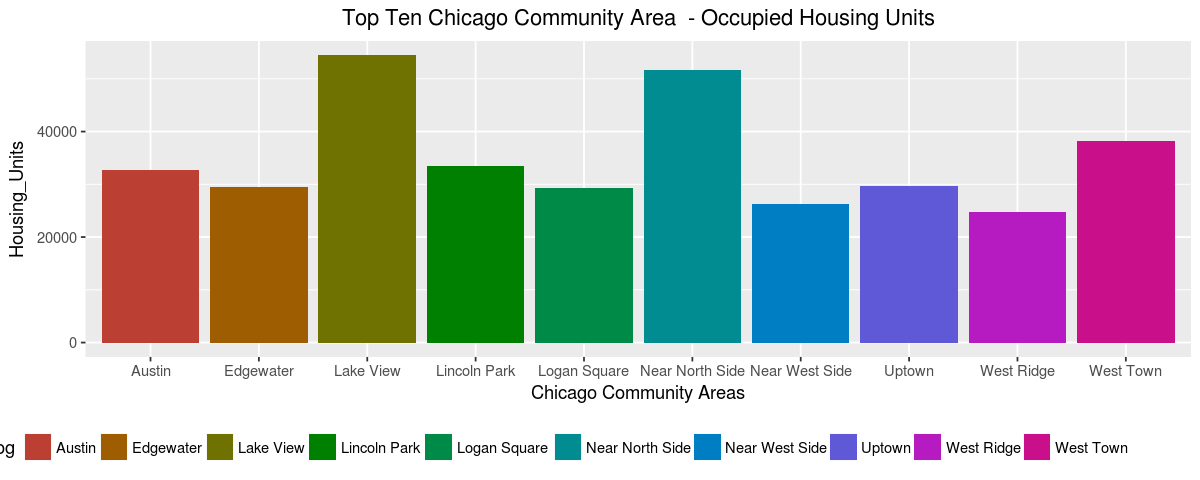

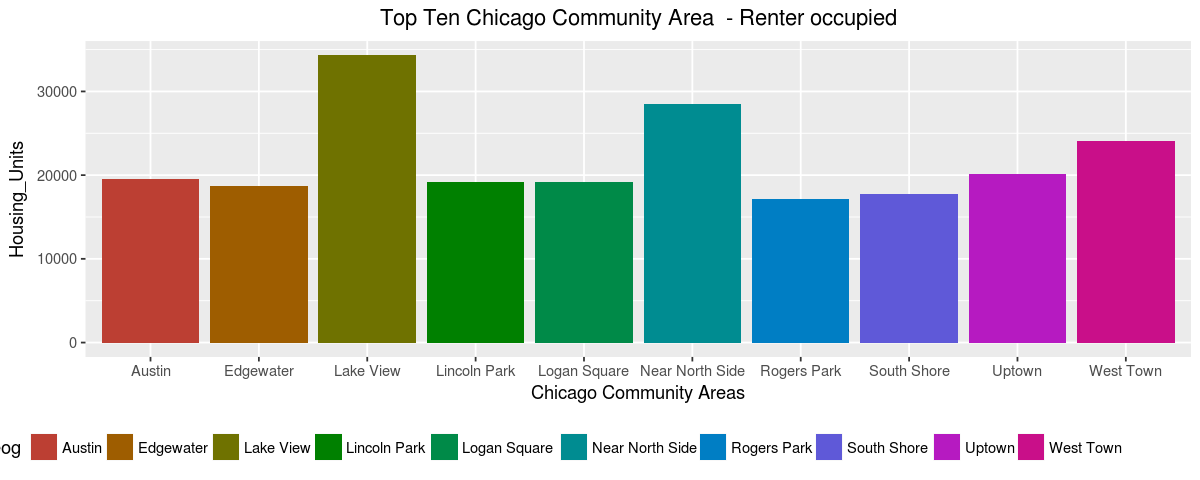

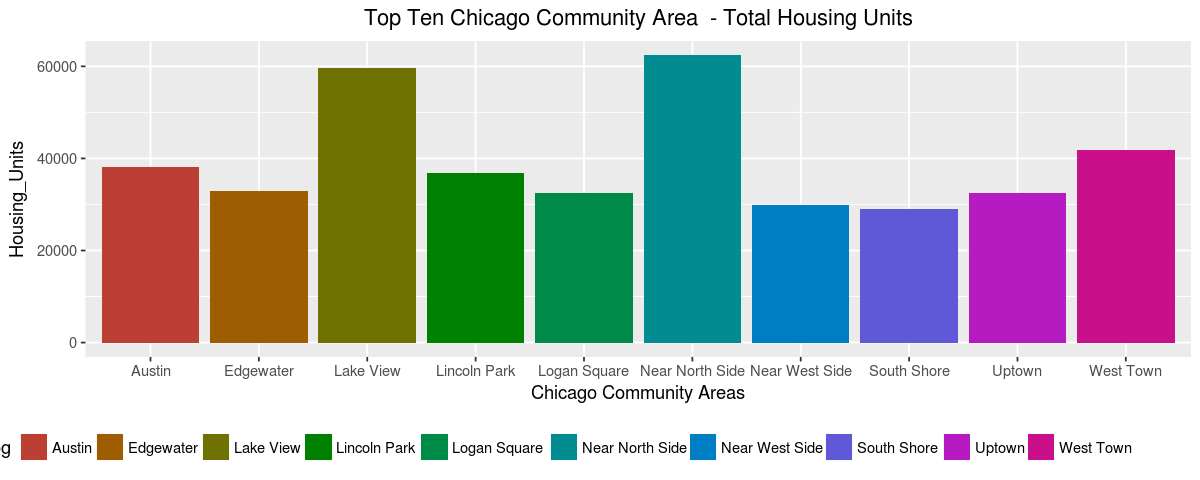

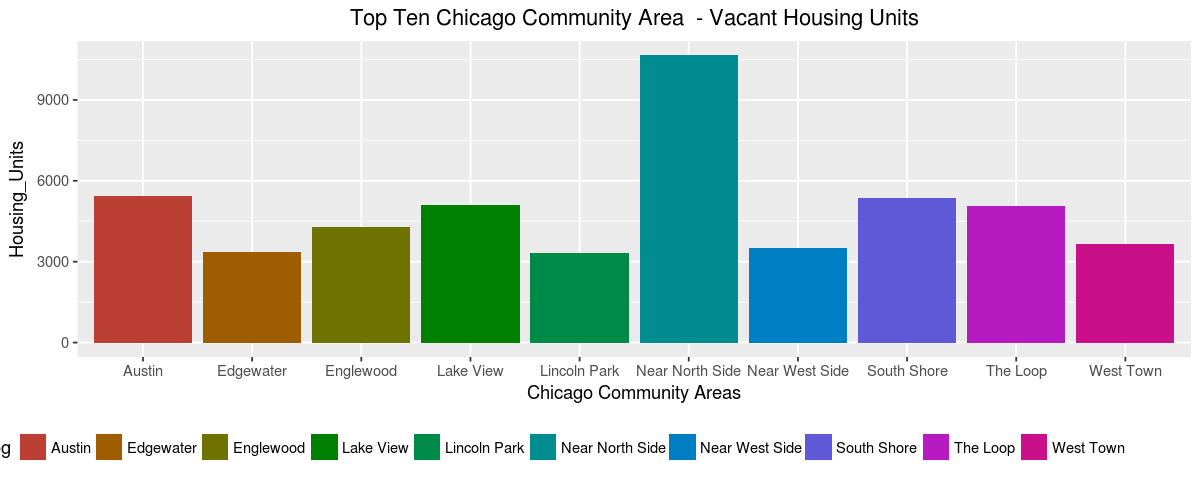

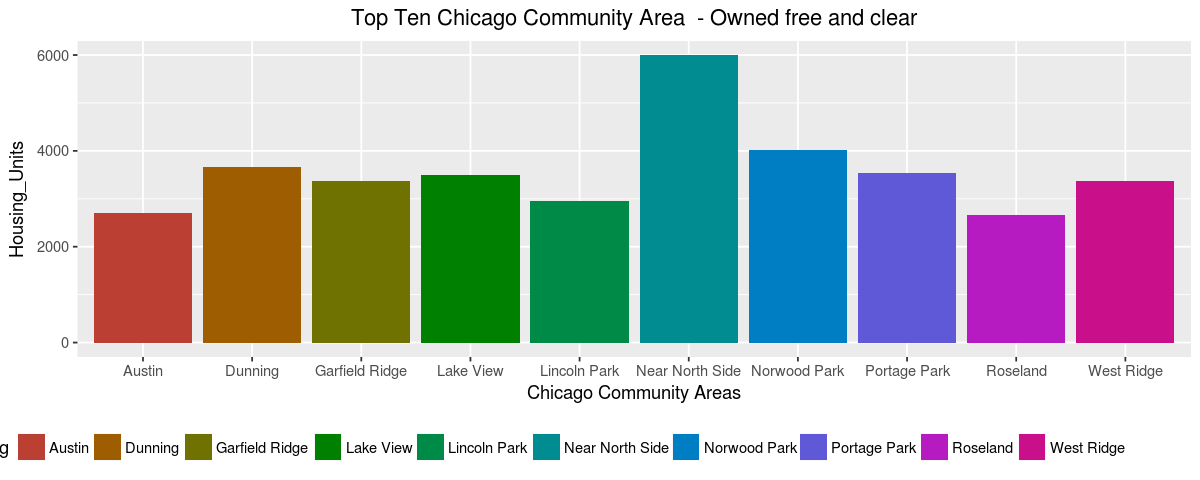

[[1]]

[[2]]
[[2]][[1]]

[[2]][[2]]

[[2]][[3]]

[[2]][[4]]

[[2]][[5]]

[[2]][[6]]

[[2]][[7]]

[[2]][[8]]


[[3]]
[[3]][[1]]

[[3]][[2]]

[[3]][[3]]

[[3]][[4]]

[[3]][[5]]

[[3]][[6]]

[[3]][[7]]

[[3]][[8]]

[[3]][[9]]

[[3]][[10]]

[[3]][[11]]

[[3]][[12]]

[[3]][[13]]

[[3]][[14]]

[[3]][[15]]

[[3]][[16]]

[[3]][[17]]

[[3]][[18]]

[[3]][[19]]

[[3]][[20]]

[[3]][[21]]

[[3]][[22]]

[[3]][[23]]


[[4]]
[[4]][[1]]

[[4]][[2]]


[[5]]
[[5]][[1]]

[[5]][[2]]

[[5]][[3]]

[[5]][[4]]

[[5]][[5]]

[[5]][[6]]


[[6]]

[[7]]
[[7]][[1]]

[[7]][[2]]

[[7]][[3]]

[[7]][[4]]


[[8]]
[[8]][[1]]

[[8]][[2]]

[[8]][[3]]



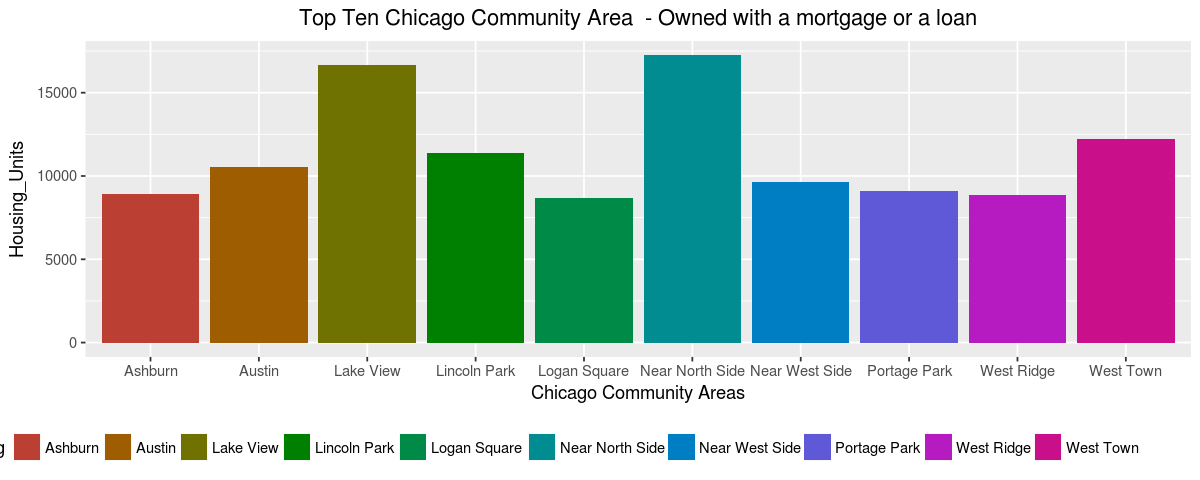

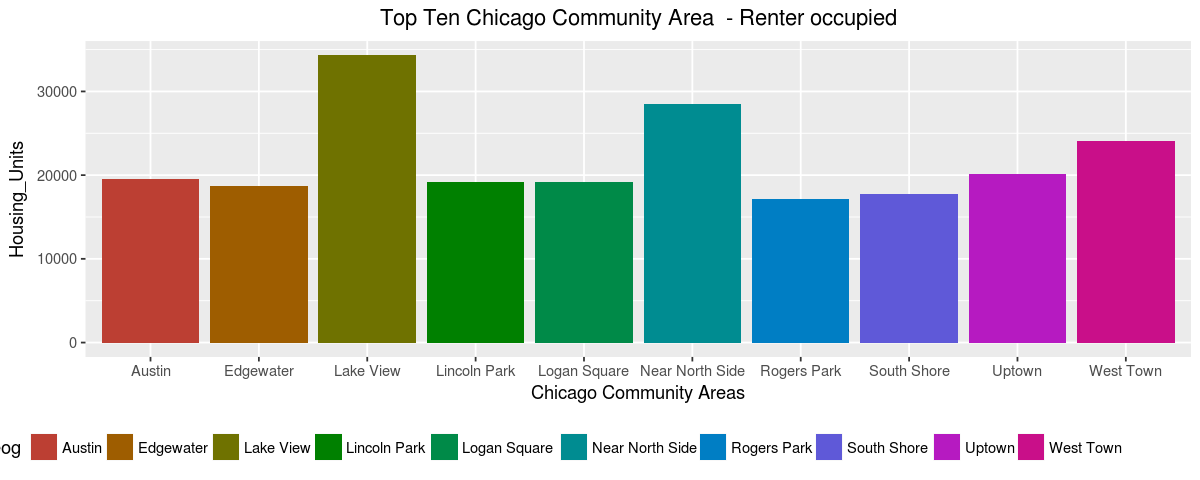

In [13]:
options(repr.plot.width=10, repr.plot.height=4)
graphing_fct()

## Microbenchmark

In [24]:
print(microbenchmark(extract_fct, reshape_fct, summarize_fct, graphing_fct))

Unit: nanoseconds
          expr min lq  mean median uq  max neval cld
   extract_fct  34 36 50.22     37 38 1344   100   a
   reshape_fct  34 36 41.31     37 38  431   100   a
 summarize_fct  34 36 41.07     38 39  354   100   a
  graphing_fct  34 36 42.36     37 39  505   100   a
